In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Note

- Generate the fake data
- Find the peak frequencys in the scans
- Fit it to the avoid crossing model to get coupling

# Generate the fake data

## 1D fake data


- From the minimum mode freq difference, one can roughly estimate the NN coupling

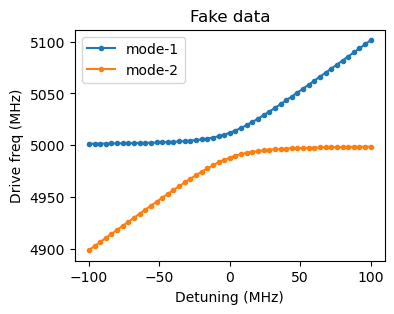

The smallest freq diff is 24.00 MHz
Estimated coupling = 12.00 MHz


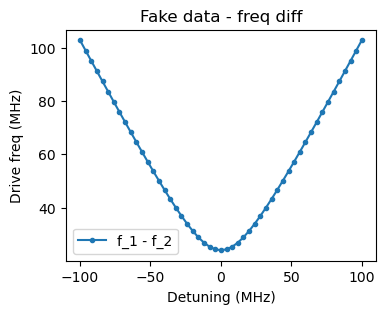

In [45]:
flux_list = np.linspace(-10,10,51)
scale = 5 ## MHz/flux unit
detuning = flux_list * scale
f0_q1 = f0_q2 = 5000
J = 12

f_high = np.sqrt(J**2+detuning**2) + detuning + f0_q1
f_low = detuning - np.sqrt(J**2+detuning**2) + f0_q1

plt.figure(figsize = (4,3), dpi = 100)
plt.plot(2*detuning,f_high, '.-', label = 'mode-1')
plt.plot(2*detuning,f_low, '.-', label = 'mode-2')
plt.legend()
plt.title('Fake data')
plt.ylabel('Drive freq (MHz)')
plt.xlabel('Detuning (MHz)')
plt.show()

plt.figure(figsize = (4,3), dpi = 100)
plt.plot(2*detuning,f_high - f_low, '.-', label = 'f_1 - f_2')
plt.legend()
plt.title('Fake data - freq diff')
plt.ylabel('Drive freq (MHz)')
plt.xlabel('Detuning (MHz)')

min_delta = np.min(f_high - f_low)
print('The smallest freq diff is %.2f MHz' %min_delta)
print('Estimated coupling = %.2f MHz' %(min_delta/2))

## To 2D data

- Generate the lineshape and add noise to the data

In [76]:
# Define the double Gaussian function
def double_gaussian(x, amp1, mean1, sigma1, amp2, mean2, sigma2):
    gaussian1 = amp1 * np.exp(-((x - mean1) ** 2) / (2 * sigma1 ** 2))
    gaussian2 = amp2 * np.exp(-((x - mean2) ** 2) / (2 * sigma2 ** 2))
    return gaussian1 + gaussian2

N_f_scan = 200
f_scan = np.linspace(min(2*detuning)*1.2, max(2*detuning)*1.2, N_f_scan) + f0_q1
sigma = 5 ## width of the gaussian
amp = 1 ## height of the gaussian

noise_mean = 0    # Mean of the noise
noise_std = 0.1   # Standard deviation of the noise


### calculate the fake 2D data ###
fake_2D_scan = np.zeros((len(detuning), len(f_scan)))

for k in range(len(detuning)):
    mean1 = f_high[k]
    mean2 = f_low[k]
    data_1D = double_gaussian(f_scan,amp,mean1, sigma, amp, mean2, sigma)
    noise = np.random.normal(noise_mean, noise_std, len(f_scan))
    fake_2D_scan[k] = data_1D + noise

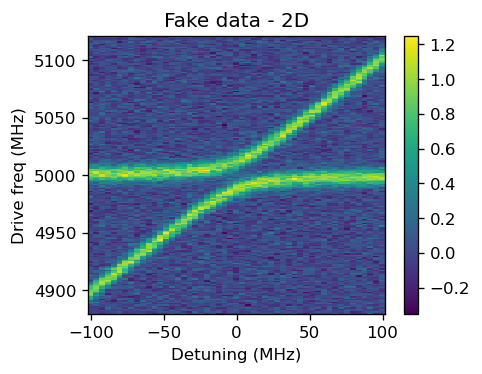

In [77]:
plt.figure(figsize = (4,3), dpi = 120)
plt.pcolor(2*detuning, f_scan, fake_2D_scan.T)
plt.colorbar()
plt.title('Fake data - 2D')
plt.ylabel('Drive freq (MHz)')
plt.xlabel('Detuning (MHz)')
plt.show()

# Analyze the fake data

- Take the inverse process of the generate the fake data

## Find and fit peaks for one slice in the 2D data
- with double Gaussian fitting
- or with double Lorentzian fitting

Note: You need to be careful about the fitting parameters, play with it to make it works for your code
- Smooth function
- Peak seperation etc.
- Initial guess

In [78]:
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter


# Define the double Gaussian function
def double_gaussian(x, amp1, mean1, sigma1, amp2, mean2, sigma2):
    gaussian1 = amp1 * np.exp(-((x - mean1) ** 2) / (2 * sigma1 ** 2))
    gaussian2 = amp2 * np.exp(-((x - mean2) ** 2) / (2 * sigma2 ** 2))
    return gaussian1 + gaussian2

# Define the double Lorentzian function
def double_lorentzian(x, amp1, center1, gamma1, amp2, center2, gamma2):
    lorentzian1 = amp1 / (1 + ((x - center1) / gamma1) ** 2)
    lorentzian2 = amp2 / (1 + ((x - center2) / gamma2) ** 2)
    return lorentzian1 + lorentzian2

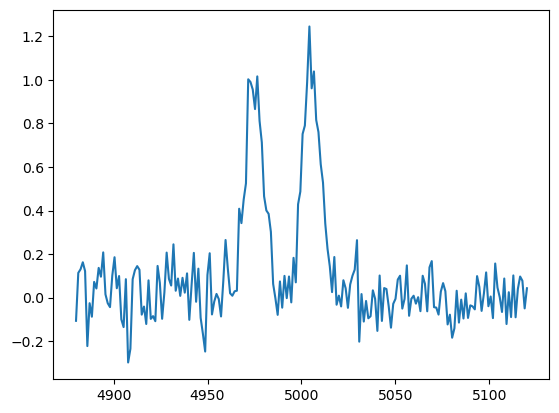

In [79]:
y_noisy_gaussian = fake_2D_scan[20]
x = f_scan

plt.plot(x,y_noisy_gaussian)

Two highest peaks (x positions): [ 77 103]
Two highest peaks (heights): [0.95068577 1.07468093]


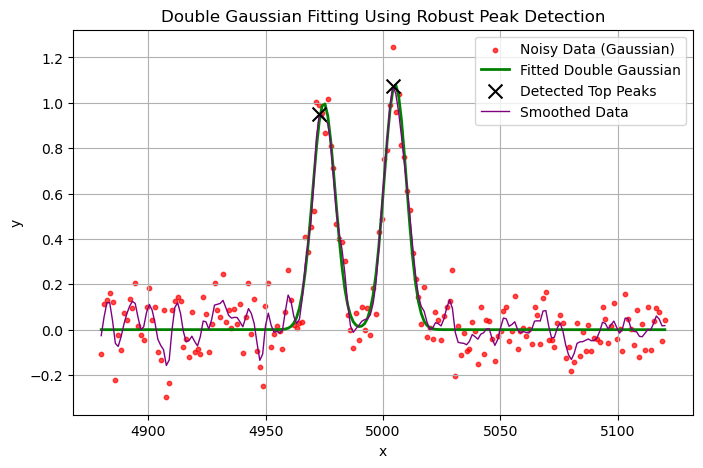

In [80]:
# Smoothing the noisy data using Gaussian filter or Savitzky-Golay filter
y_smoothed_gaussian = gaussian_filter1d(y_noisy_gaussian, sigma=1)  # Gaussian filter
# y_smoothed_gaussian = savgol_filter(y_noisy_gaussian, window_length=11, polyorder=3)  # Uncomment to use Savitzky-Golay

# Detect peaks in the smoothed data
peaks, properties = find_peaks(
    y_smoothed_gaussian,
    height=0,        # Minimum height
    distance=15,     # Minimum distance between peaks
    prominence=0.5,  # Minimum prominence to qualify as a peak
    width=3          # Minimum width of peaks
)

# Get the two highest peaks after filtering
peak_heights = properties['peak_heights']
sorted_indices = np.argsort(peak_heights)[-2:]  # Indices of the two highest peaks
top_peaks = peaks[sorted_indices]
top_heights = peak_heights[sorted_indices]

# Ensure the peaks are in ascending order of x for fitting
if top_peaks[0] > top_peaks[1]:
    top_peaks = top_peaks[::-1]
    top_heights = top_heights[::-1]

print("Two highest peaks (x positions):", top_peaks)
print("Two highest peaks (heights):", top_heights)

# Use the two highest peaks for initial guesses
initial_guess_gaussian = [
    top_heights[0], x[top_peaks[0]], 10,  # First Gaussian: amplitude, mean, sigma
    top_heights[1], x[top_peaks[1]], 10   # Second Gaussian: amplitude, mean, sigma
]

# Fit the noisy data with the double Gaussian function
popt_gaussian, pcov_gaussian = curve_fit(double_gaussian, x, y_noisy_gaussian, p0=initial_guess_gaussian)

# Compute the fitted curve
y_fitted_gaussian = double_gaussian(x, *popt_gaussian)

# Plot Gaussian fitting results
plt.figure(figsize=(8, 5))
plt.scatter(x, y_noisy_gaussian, label='Noisy Data (Gaussian)', color='r', s=10, alpha=0.7)
plt.plot(x, y_fitted_gaussian, label='Fitted Double Gaussian', color='g', linestyle='-', linewidth=2)
plt.scatter(x[top_peaks], top_heights, color='black', label='Detected Top Peaks', zorder=5, marker='x', s=100)
plt.plot(x, y_smoothed_gaussian, label='Smoothed Data', color='purple', linestyle='-', linewidth=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Double Gaussian Fitting Using Robust Peak Detection')
plt.legend()
plt.grid()
plt.show()


## Extend this analysis to the whole 2D data
- Do 3.1 for each vertical slices of the 2D data

In [81]:
config_find_peak = {
    "filter_sigma": 1, # sigma for smooth filter
    "height":0,        # Minimum height
    "distance":15,     # Minimum distance between peaks
    "prominence":0.5,  # Minimum prominence to qualify as a peak
    "width":3          # Minimum width of peaks
}

config_fit_guess = {
    "sigma":10,        # Peak width inital guess
}

f_high_fit = np.zeros(len(detuning))
f_low_fit = np.zeros(len(detuning))

for k in range(len(detuning)):
    
    y_noisy_gaussian = y_noisy_gaussian = fake_2D_scan[k]
    x = f_scan
    
    # Smoothing the noisy data using Gaussian filter or Savitzky-Golay filter
    y_smoothed_gaussian = gaussian_filter1d(y_noisy_gaussian, sigma=config_find_peak["filter_sigma"])  # Gaussian filter
    # y_smoothed_gaussian = savgol_filter(y_noisy_gaussian, window_length=11, polyorder=3)  # Uncomment to use Savitzky-Golay

    # Detect peaks in the smoothed data
    peaks, properties = find_peaks(
        y_smoothed_gaussian,
        height=config_find_peak["height"],          # Minimum height
        distance=config_find_peak["distance"],      # Minimum distance between peaks
        prominence=config_find_peak["prominence"],  # Minimum prominence to qualify as a peak
        width=config_find_peak["width"]             # Minimum width of peaks
    )

    # Get the two highest peaks after filtering
    peak_heights = properties['peak_heights']
    sorted_indices = np.argsort(peak_heights)[-2:]  # Indices of the two highest peaks
    top_peaks = peaks[sorted_indices]
    top_heights = peak_heights[sorted_indices]

    # Ensure the peaks are in ascending order of x for fitting
    if top_peaks[0] > top_peaks[1]:
        top_peaks = top_peaks[::-1]
        top_heights = top_heights[::-1]

    # Use the two highest peaks for initial guesses
    initial_guess_gaussian = [
        top_heights[0], x[top_peaks[0]], config_fit_guess["sigma"],  # First Gaussian: amplitude, mean, sigma
        top_heights[1], x[top_peaks[1]], config_fit_guess["sigma"]   # Second Gaussian: amplitude, mean, sigma
    ]

    # Fit the noisy data with the double Gaussian function
    popt_gaussian, pcov_gaussian = curve_fit(double_gaussian, x, y_noisy_gaussian, p0=initial_guess_gaussian)
    
    if popt_gaussian[1]> popt_gaussian[4]:
        f_high_fit[k] = popt_gaussian[1]
        f_low_fit[k] = popt_gaussian[4]
    else:
        f_high_fit[k] = popt_gaussian[4]
        f_low_fit[k] = popt_gaussian[1]

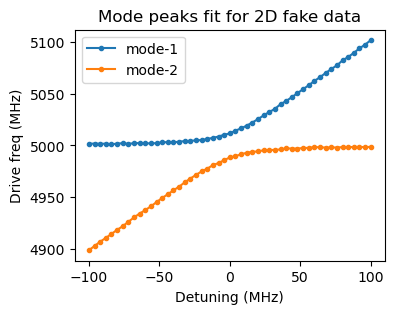

The smallest freq diff is 23.29 MHz
Estimated coupling = 11.64 MHz


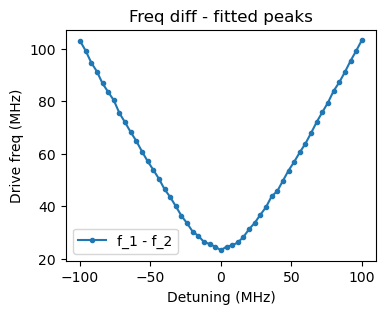

In [84]:
plt.figure(figsize = (4,3), dpi = 100)
plt.plot(2*detuning,f_high_fit, '.-', label = 'mode-1')
plt.plot(2*detuning,f_low_fit, '.-', label = 'mode-2')
plt.legend()
plt.title('Mode peaks fit for 2D fake data')
plt.ylabel('Drive freq (MHz)')
plt.xlabel('Detuning (MHz)')
plt.show()

plt.figure(figsize = (4,3), dpi = 100)
plt.plot(2*detuning,f_high_fit - f_low_fit, '.-', label = 'f_1 - f_2')
plt.legend()
plt.title('Freq diff - fitted peaks')
plt.ylabel('Drive freq (MHz)')
plt.xlabel('Detuning (MHz)')

min_delta = np.min(f_high_fit - f_low_fit)
print('The smallest freq diff is %.2f MHz' %min_delta)
print('Estimated coupling = %.2f MHz' %(min_delta/2))

## Perform the fitting for the avoid crossing model

- remove offset etc.
- find the inital guess
- define the model and fit it with data
- summary for the fit

From fitting, J = 11.90 MHz


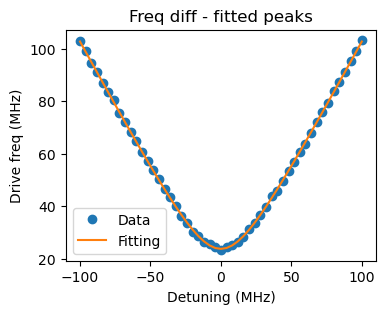

In [92]:
def diff_crossing(detuning_list, g):
    return np.sqrt(detuning_list**2 + 4*g**2)


exper_fit_diff = f_high_fit - f_low_fit
g_guess = np.min(exper_fit_diff)/2

x = 2*detuning

# Fit the noisy data with the double Gaussian function
popt_fit, pcov_fit = curve_fit(diff_crossing, x , exper_fit_diff, p0=[g_guess])

# Compute the fitted curve
y_fit = diff_crossing(x , *popt_fit)

plt.figure(figsize = (4,3), dpi = 100)
plt.plot(x ,exper_fit_diff, 'o', label = 'Data')
plt.plot(x ,y_fit, '-', label = 'Fitting')
plt.legend()
plt.title('Freq diff - fitted peaks')
plt.ylabel('Drive freq (MHz)')
plt.xlabel('Detuning (MHz)')

print("From fitting, J = %.2f MHz" %(popt_fit))